# Exploration notebook

In this notebook you can find the the explorations done regarding the project. It contains the following sections:
- 1. Imports
- 2. Ingestion
- 3. Preprocessing
- 4. Feature selection
- 5. Feature engineering
- 6. Training the model(s)


<a id='f'></a>
# 1. Imports

In this section we import the necessary packages

In [106]:
import pandas as pd
import numpy as np
import xlrd
from pathlib import Path
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import predict_interval

from sklearn.metrics import mean_absolute_error, r2_score

from sklego.preprocessing import RepeatingBasisFunction

import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline 

ImportError: cannot import name 'predict_interval' from 'sklearn.inspection' (/usr/local/lib/python3.10/site-packages/sklearn/inspection/__init__.py)

<a id='f'></a>
# 2. Ingestion

In this section, we read in the greenhouse data from the Automatoes team and the weather data.

In [95]:
team = "Automatoes"

In [96]:
path_greenhouse_csv = os.path.abspath(f'../data/{team}/GreenhouseClimate.csv')

path_weather_csv = os.path.abspath(f'../data/Weather.csv')

In [97]:
df_greenhouse = pd.read_csv(path_greenhouse_csv)
df_weather = pd.read_csv(path_weather_csv)

<a id='f'></a>
# 3. Preprocessing

In this section we preprocess the data

In [98]:
df_greenhouse = (df_greenhouse
        .assign(time = lambda df: df["time"].apply(lambda col: pd.Timestamp(xlrd.xldate_as_datetime(col, 0))))
        .set_index('time'))

df_weather = (df_weather
        .assign(time = lambda df: df["time"].apply(lambda col: pd.Timestamp(xlrd.xldate_as_datetime(col, 0))))
        .set_index('time'))

data = df_weather.join(df_greenhouse)

<a id='f'></a>
# 4. Feature selection

In this section, we select the features that we want to keep

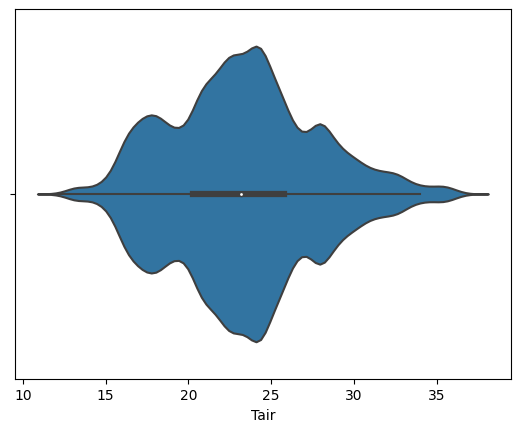

In [7]:
# A check wether we have sufficient variation in Tair across the dataset
sns.violinplot(x="Tair", data = data);

In [8]:
# Check which columns have a lot of missing values
number_of_entries = len(data.index)
missing_values = (data
                  .isna()
                  .sum()
                  .to_frame(name="number_missing_values")
                  .assign(percentage_missing = lambda df: df["number_missing_values"]/number_of_entries*100)
                  .loc[lambda df: df["percentage_missing"] > 5.0]
                 )
missing_values

,number_missing_values,percentage_missing
int_blue_vip,22152,46.334372
int_farred_vip,22152,46.334372
int_red_vip,22152,46.334372
int_white_vip,22152,46.334372
t_vent_sp,12576,26.304671


In [9]:
# Drop columns which have too many missing values
data = data.drop(columns=['int_blue_vip','int_farred_vip','int_red_vip','int_white_vip','t_vent_sp'])

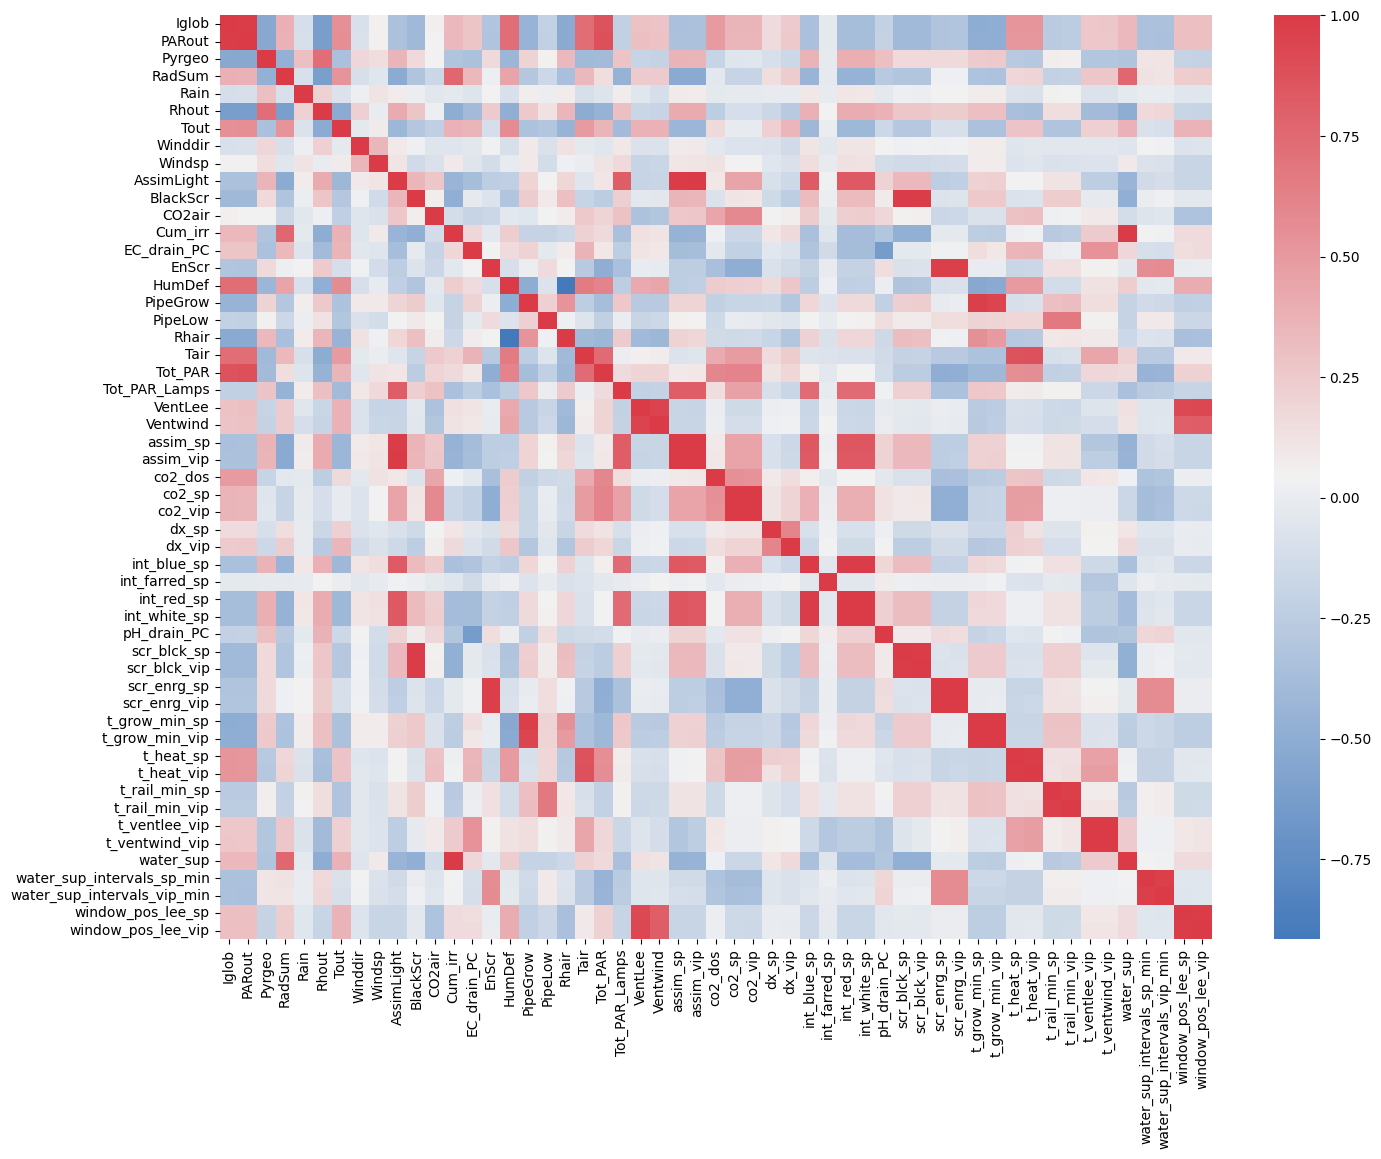

In [10]:
# Check the correlation between the different features
fig, ax = plt.subplots(figsize = (16,12))
sns.heatmap(data.iloc[:, 1:].corr(), cmap = sns.diverging_palette(250, 10, as_cmap=True), ax = ax);

In [11]:
# Filter on the features that have a significant correlation
df_correlated_features = (data
                       .iloc[:, 1:]
                       .corr()
                       .loc["Tair"]
                       .to_frame(name="correlation_Tair")
                       .loc[lambda df: abs(df["correlation_Tair"])>0.50]
                      )
correlated_features = list(df_correlated_features.index.values)
data = data[correlated_features]

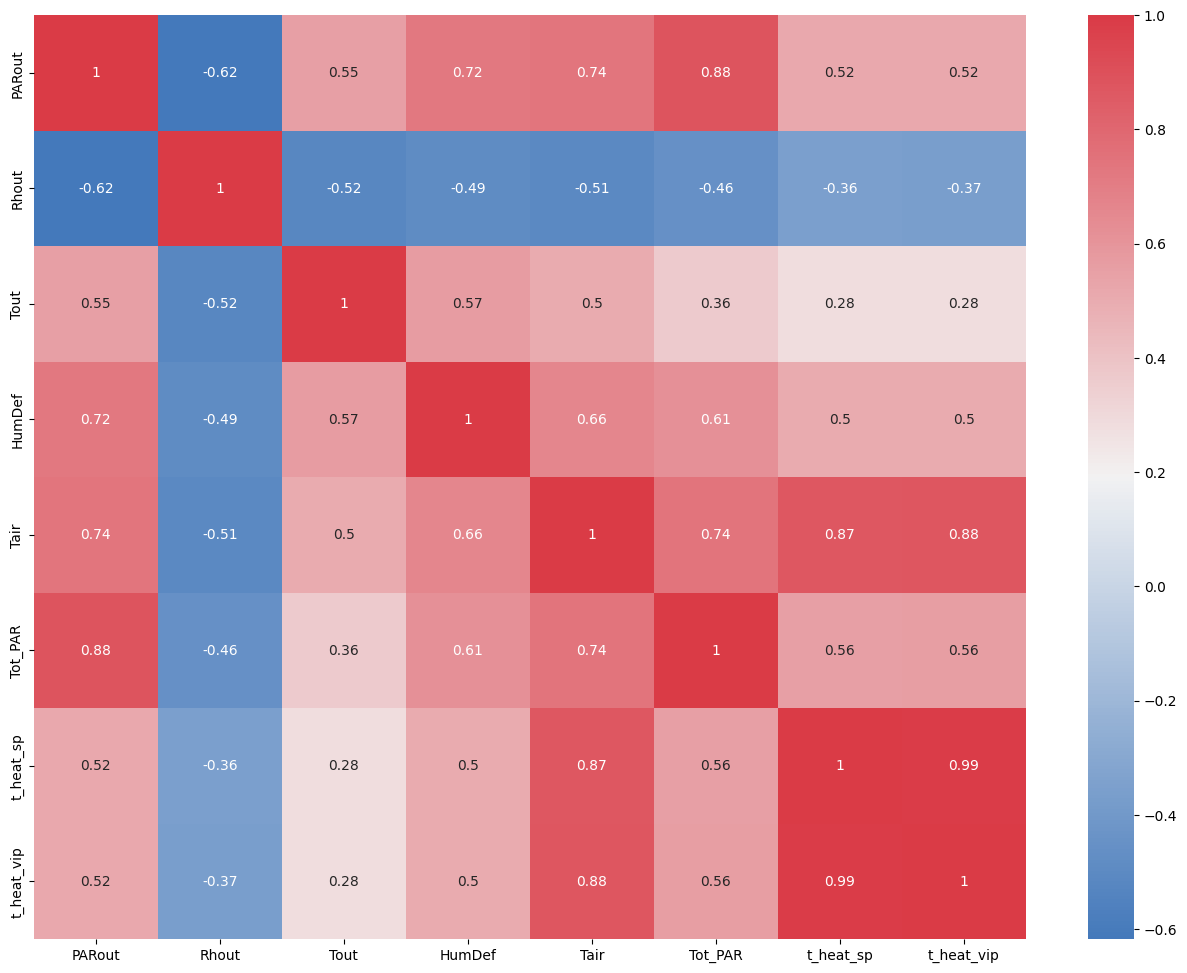

In [12]:
# Check the correlation between the different significant features
fig, ax = plt.subplots(figsize = (16,12))
sns.heatmap(data.iloc[:, 1:].corr(),annot=True, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax = ax);

In [13]:
# Drop columns which are too correlated with each other
data = data.drop(columns=['Tot_PAR','t_heat_vip'])

In [14]:
# Fill the remaining NaN values with the average and resample to 1 hours
data = data.fillna(data.mean()).resample('1H').mean()

In [15]:
data

,Iglob,PARout,Rhout,Tout,HumDef,Tair,t_heat_sp
time,,,,,,,
2019-12-16 00:00:00,0.000000,0.000000,81.250000,6.791667,7.051667,21.450000,21.392907
2019-12-16 01:00:00,0.000000,0.000000,84.123077,6.292308,7.271538,21.038462,21.392907
2019-12-16 02:00:00,0.000000,0.000000,85.636364,6.136364,7.063636,21.036364,21.392907
2019-12-16 03:00:00,0.000000,0.000000,88.225000,6.083333,7.061667,21.025000,21.392907
2019-12-16 04:00:00,0.000000,0.000000,90.276923,6.023077,6.912308,20.892308,21.392907
...,...,...,...,...,...,...,...
2020-05-29 20:00:00,115.363637,223.636364,44.718182,19.245455,11.234545,22.381818,10.000000
2020-05-29 21:00:00,20.416667,44.916667,62.333333,17.425000,7.255833,20.116667,10.000000
2020-05-29 22:00:00,0.000000,0.923077,68.300000,16.038462,5.021538,18.676923,10.000000


<a id='f'></a>
# 5. Feature engineering

In this section, we generate extra features that are useful for the model

In [16]:
data = (data
       .assign(t=lambda df: np.arange(len(df.index)) - (len(df.index) -1),
            hour_of_day=lambda df: df.index.hour,
            month=lambda df: df.index.month))

In [17]:
data

,Iglob,PARout,Rhout,Tout,HumDef,Tair,t_heat_sp,t,hour_of_day,month
time,,,,,,,,,,
2019-12-16 00:00:00,0.000000,0.000000,81.250000,6.791667,7.051667,21.450000,21.392907,-3984,0,12
2019-12-16 01:00:00,0.000000,0.000000,84.123077,6.292308,7.271538,21.038462,21.392907,-3983,1,12
2019-12-16 02:00:00,0.000000,0.000000,85.636364,6.136364,7.063636,21.036364,21.392907,-3982,2,12
2019-12-16 03:00:00,0.000000,0.000000,88.225000,6.083333,7.061667,21.025000,21.392907,-3981,3,12
2019-12-16 04:00:00,0.000000,0.000000,90.276923,6.023077,6.912308,20.892308,21.392907,-3980,4,12
...,...,...,...,...,...,...,...,...,...,...
2020-05-29 20:00:00,115.363637,223.636364,44.718182,19.245455,11.234545,22.381818,10.000000,-4,20,5
2020-05-29 21:00:00,20.416667,44.916667,62.333333,17.425000,7.255833,20.116667,10.000000,-3,21,5
2020-05-29 22:00:00,0.000000,0.923077,68.300000,16.038462,5.021538,18.676923,10.000000,-2,22,5


<a id='f'></a>
# 6. Training the model(s)

In this section we train several models to see which one is best. First we split the data correctly in train and test and visualise it.

In [75]:
# Prepare the training and testing data
all_data = data.copy()

train = all_data.loc[:'2020-05-29']
test = all_data.loc['2020-05-29':]

X_train = train.drop(columns="Tair")
y_train = train[['Tair']]
X_test = test.drop(columns="Tair")
y_test = test[['Tair']]

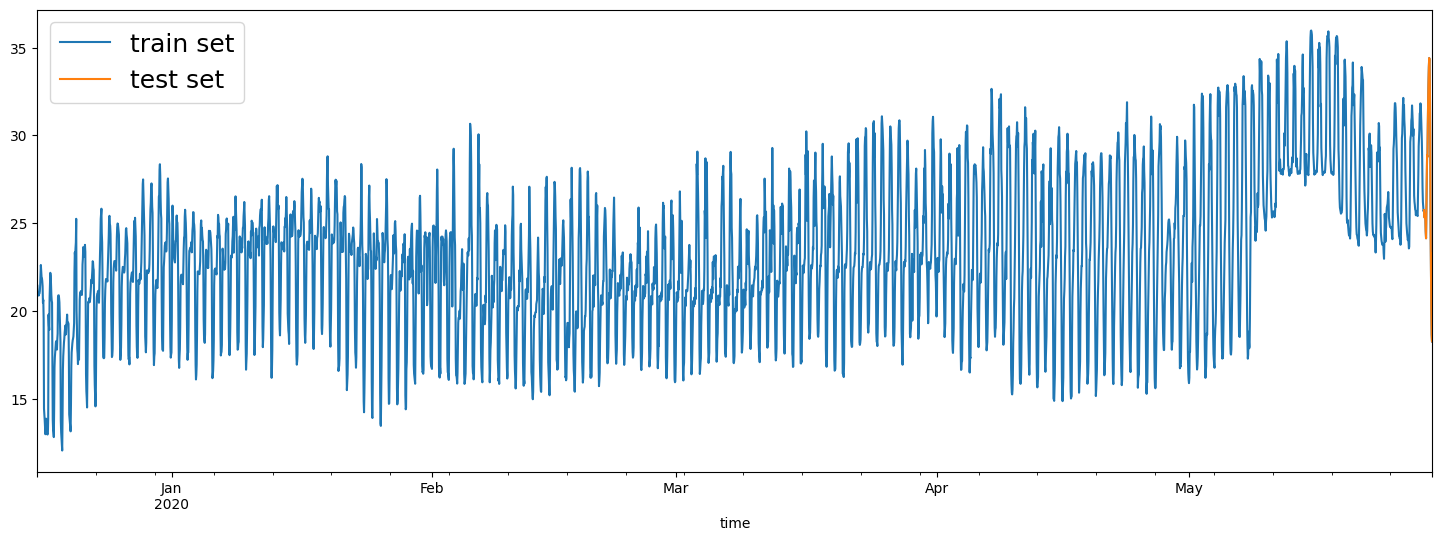

In [76]:
# Visualisation of the training and testing data.
fig, ax = plt.subplots(figsize=(18,6))
train['Tair'].plot(ax=ax)
test['Tair'].plot(ax=ax)
ax.legend(["train set", "test set"], prop={'size': 18});

<a id='f'></a>
## Simple Linear Regression

In this section we train a simple linear regression model (no cross-validation). 

In [77]:
rbf = RepeatingBasisFunction(n_periods=24,
                             remainder='passthrough',
                             column='hour_of_day')
model = Pipeline([
    ('preprocess', rbf),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

lm = model.fit(X_train, y_train)
all_data['lm_pred'] = lm.predict(all_data.drop(columns="Tair"))

In [78]:
train_pred = lm.predict(X_train)
test_pred = lm.predict(X_test)

In [79]:
# Calculate scores. 
r2_train = r2_score(y_train, train_pred).round(3)
mae_train = mean_absolute_error(y_train, train_pred).round(3)

r2_test = r2_score(y_test, test_pred).round(3)
mae_test = mean_absolute_error(y_test, test_pred).round(3)

# Report. 
print(f'TRAIN | r2 score: {r2_train}')
print(f'TRAIN | MAE: {mae_train}')
print(f'TEST | r2 score: {r2_test}')
print(f'TEST | MAE: {mae_test}')

TRAIN | r2 score: 0.903
TRAIN | MAE: 0.976
TEST | r2 score: 0.424
TEST | MAE: 2.439


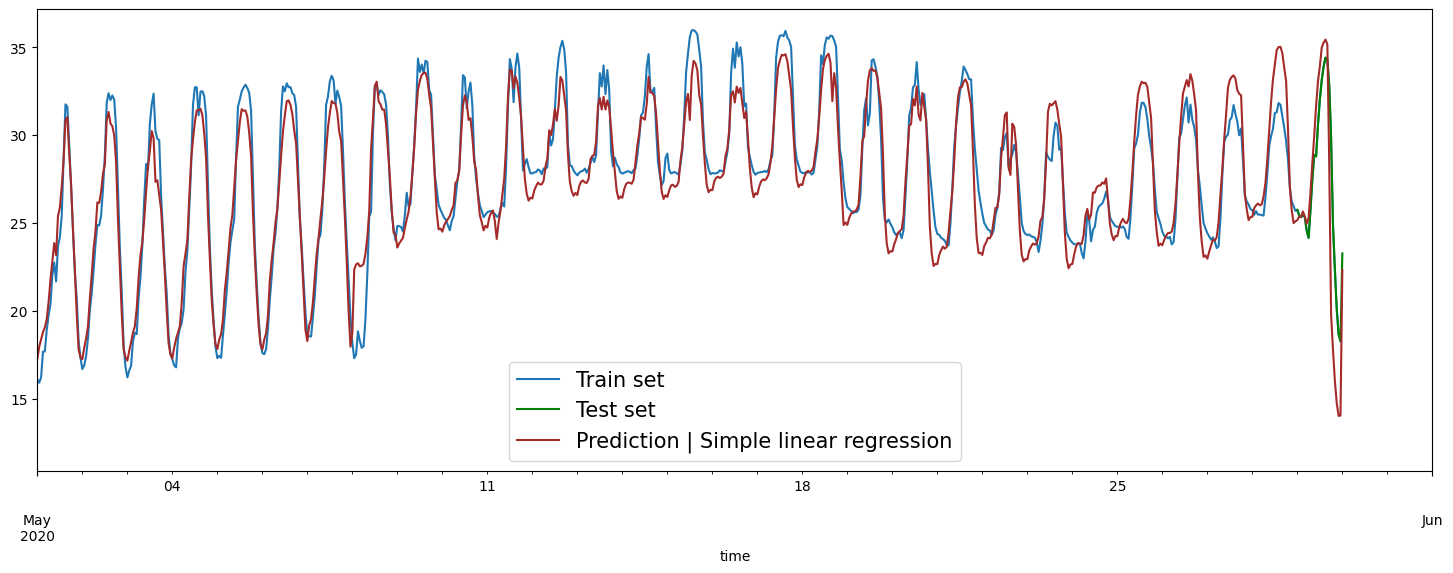

In [80]:
fig, ax = plt.subplots(figsize=(18,6))
train[['Tair']].plot(ax=ax)
test[['Tair']].plot(ax=ax, c='g')
all_data[['lm_pred']].plot(ax=ax, c='brown')
ax.legend(["Train set", "Test set", "Prediction | Simple linear regression"], prop={'size': 15});
plt.xlim(pd.Timestamp('2020-05-01'), pd.Timestamp('2020-06-01'));

<a id='f'></a>
## Training model (Linear Regression + GridSearchCV)

In this section we train a linear regression model with GridSearchCV. 

In [81]:
rbf = RepeatingBasisFunction(n_periods=24,
                             remainder='passthrough',
                             column='hour_of_day')
model = Pipeline([
    ('preprocess', rbf),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

parameters = {
    'model__fit_intercept':[True, False]
}

tscv = TimeSeriesSplit(n_splits=6)

for train_index, test_index in tscv.split(X_train):
    print(f"TRAIN: [{train_index.min(), train_index.max()}]", 
         f"TEST: [{test_index.min(), test_index.max()}]")

TRAIN: [(0, 569)] TEST: [(570, 1138)]
TRAIN: [(0, 1138)] TEST: [(1139, 1707)]
TRAIN: [(0, 1707)] TEST: [(1708, 2276)]
TRAIN: [(0, 2276)] TEST: [(2277, 2845)]
TRAIN: [(0, 2845)] TEST: [(2846, 3414)]
TRAIN: [(0, 3414)] TEST: [(3415, 3983)]


In [82]:
gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=parameters)

gsearch.fit(X_train, y_train)

all_data['grid_pred'] = gsearch.predict(all_data.drop(columns="Tair"))

In [83]:
train_pred = gsearch.predict(X_train)
test_pred = gsearch.predict(X_test)

In [84]:
# Calculate scores. 
r2_train = r2_score(y_train, train_pred).round(3)
mae_train = mean_absolute_error(y_train, train_pred).round(3)

r2_test = r2_score(y_test, test_pred).round(3)
mae_test = mean_absolute_error(y_test, test_pred).round(3)

# Report. 
print(f'TRAIN | r2 score: {r2_train}')
print(f'TRAIN | MAE: {mae_train}')
print(f'TEST | r2 score: {r2_test}')
print(f'TEST | MAE: {mae_test}')

TRAIN | r2 score: 0.903
TRAIN | MAE: 0.976
TEST | r2 score: 0.424
TEST | MAE: 2.439


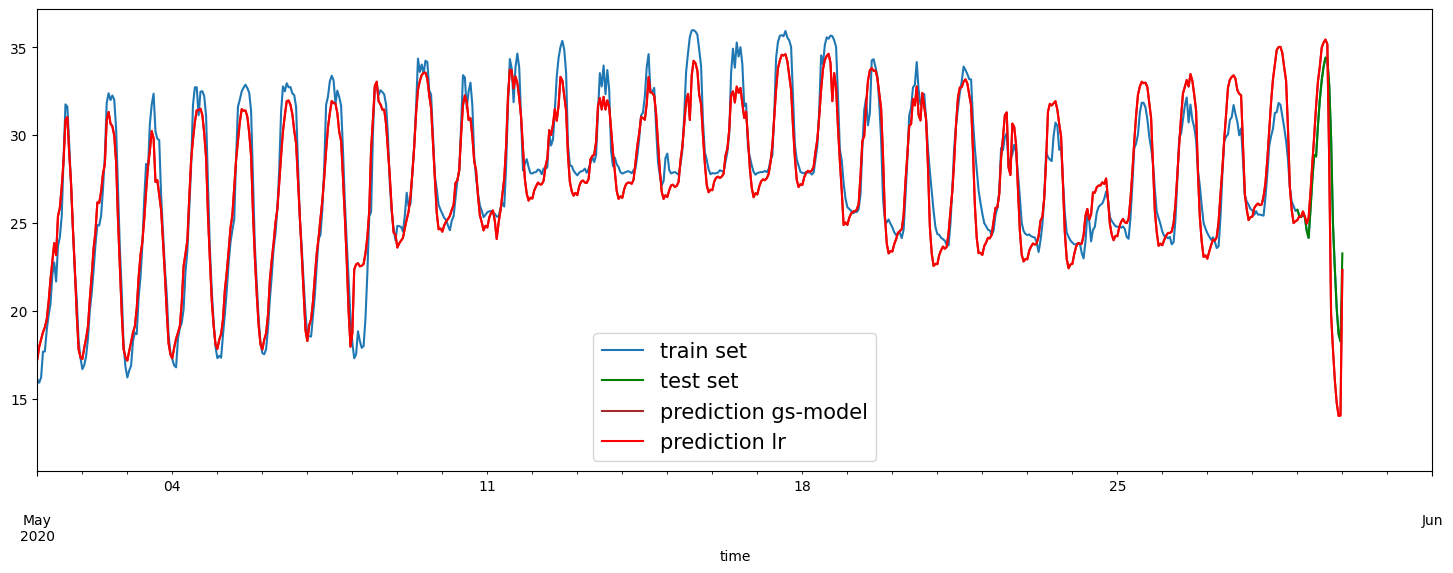

In [85]:
fig, ax = plt.subplots(figsize=(18,6))
train[['Tair']].plot(ax=ax)
test[['Tair']].plot(ax=ax, c='g')
all_data[['grid_pred']].loc['2020 May':].plot(ax=ax, c='brown')
all_data[['lm_pred']].loc['2020 May':].plot(ax=ax, c='red')
# data_own[['smoothed']].loc['2010 May':].plot(ax=ax, c='orange')
ax.legend(["train set", "test set", "prediction gs-model", "prediction lr"], prop={'size': 15});
plt.xlim(pd.Timestamp('2020-05-01'), pd.Timestamp('2020-06-01'));

<a id='f'></a>
## Training model (Random Forest + GridSearchCV)

In this section we train a Random Forest model with GridSearchCV. 

In [86]:
rbf = RepeatingBasisFunction(n_periods=24,
                             remainder='passthrough',
                             column='hour_of_day')
model = Pipeline([
    ('preprocess', rbf),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

parameters = {
    'model__max_depth':[1,2,3,4,5,7,8,9,10]
}

tscv = TimeSeriesSplit(n_splits=6)

for train_index, test_index in tscv.split(X_train):
    print(f"TRAIN: [{train_index.min(), train_index.max()}]", 
         f"TEST: [{test_index.min(), test_index.max()}]")

TRAIN: [(0, 569)] TEST: [(570, 1138)]
TRAIN: [(0, 1138)] TEST: [(1139, 1707)]
TRAIN: [(0, 1707)] TEST: [(1708, 2276)]
TRAIN: [(0, 2276)] TEST: [(2277, 2845)]
TRAIN: [(0, 2845)] TEST: [(2846, 3414)]
TRAIN: [(0, 3414)] TEST: [(3415, 3983)]


In [87]:
gsearch_rf = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=parameters) 


gsearch_rf.fit(X_train, y_train)

all_data['grid_pred_rf'] = gsearch_rf.predict(all_data.drop(columns="Tair"))

/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

In [88]:
train_pred = gsearch_rf.predict(X_train)
test_pred = gsearch_rf.predict(X_test)

In [89]:
# Calculate scores. 
r2_train = r2_score(y_train, train_pred).round(3)
mae_train = mean_absolute_error(y_train, train_pred).round(3)

r2_test = r2_score(y_test, test_pred).round(3)
mae_test = mean_absolute_error(y_test, test_pred).round(3)

# Report. 
print(f'TRAIN | r2 score: {r2_train}')
print(f'TRAIN | MAE: {mae_train}')
print(f'TEST | r2 score: {r2_test}')
print(f'TEST | MAE: {mae_test}')

TRAIN | r2 score: 0.982
TRAIN | MAE: 0.43
TEST | r2 score: 0.97
TEST | MAE: 0.498


In [105]:
conf_int = predict_interval(gsearch_rf, X_test, alpha=0.1)

NameError: name 'predict_interval' is not defined

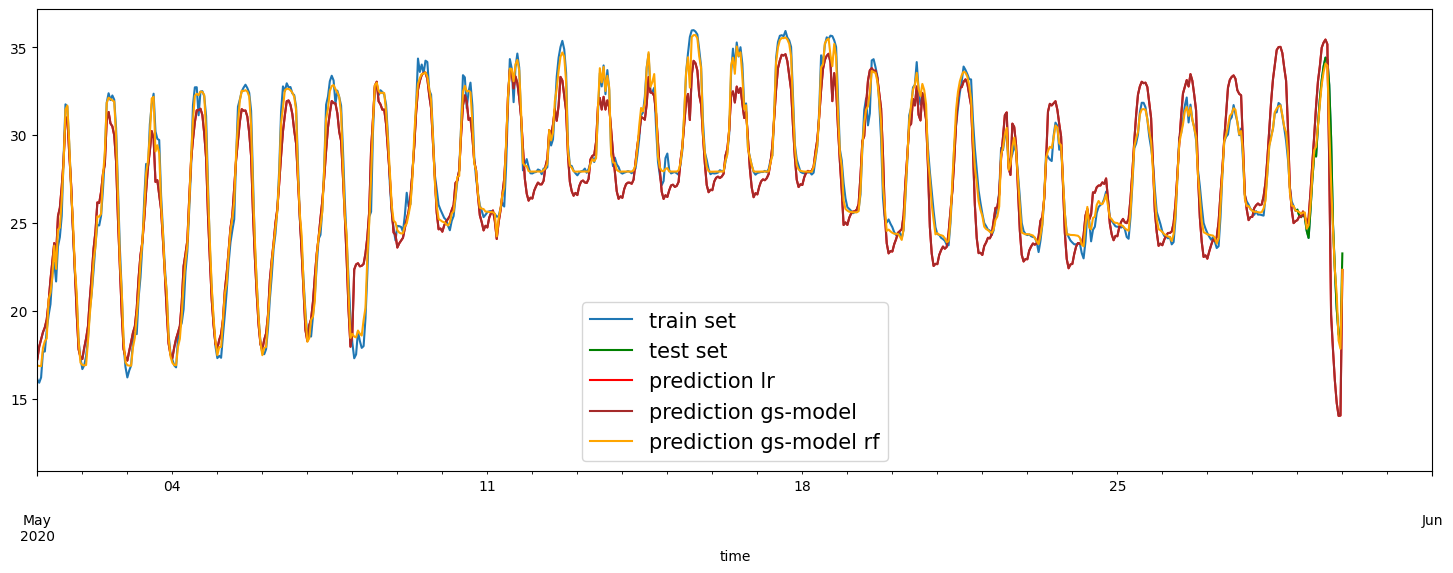

In [90]:
fig, ax = plt.subplots(figsize=(18,6))
train[['Tair']].plot(ax=ax)
test[['Tair']].plot(ax=ax, c='g')
all_data[['lm_pred']].loc['2020 May':].plot(ax=ax, c='red')
all_data[['grid_pred']].loc['2020 May':].plot(ax=ax, c='brown')
all_data[['grid_pred_rf']].loc['2010 May':].plot(ax=ax, c='orange')
ax.legend(["train set", "test set", "prediction lr", "prediction gs-model", "prediction gs-model rf"], prop={'size': 15});
plt.xlim(pd.Timestamp('2020-05-01'), pd.Timestamp('2020-06-01'));

<a id='f'></a>
## Loading model

In [91]:
import pickle

In [92]:
loaded_model = pickle.load(open("/Users/aaroneisses/Desktop/source_application/mlruns/0/0c395cd780c64bcba89eefff16c57e2b/artifacts/model/model.pkl", 'rb'))


In [93]:
all_data['vscode'] = loaded_model.predict(all_data.drop(columns="Tair"))

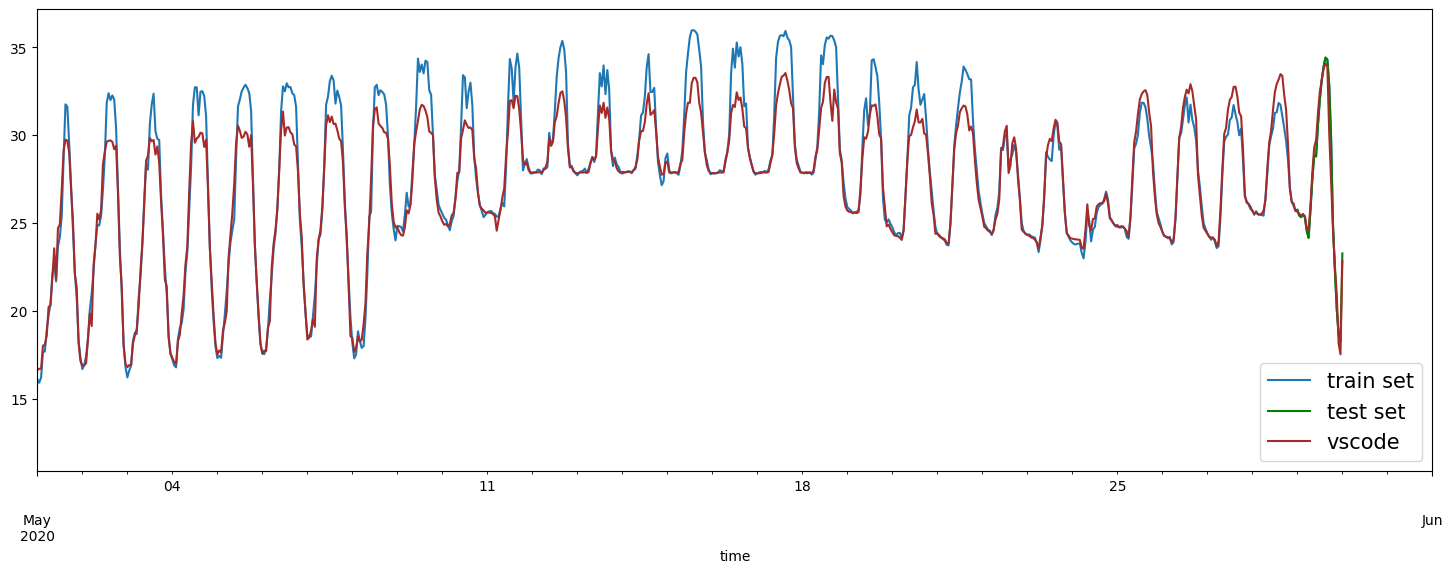

In [94]:
fig, ax = plt.subplots(figsize=(18,6))
train[['Tair']].plot(ax=ax)
test[['Tair']].plot(ax=ax, c='g')
all_data[['vscode']].loc['2020 May':].plot(ax=ax, c='brown')
# all_data[['lm_pred']].loc['2020 May':].plot(ax=ax, c='red')
# all_data[['grid_pred_rf']].loc['2010 May':].plot(ax=ax, c='orange')
ax.legend(["train set", "test set", "vscode", "prediction lr", "prediction gs-model rf"], prop={'size': 15});
plt.xlim(pd.Timestamp('2020-05-01'), pd.Timestamp('2020-06-01'));